# Machine Learning

#### In this notebook we'll show the results of different preprocessing steps used on the data to predict falls using SVM models and Convolutional Neural Network models. 

#### SVMs were picked due to being the best model used to predict falls in research that uses similar types of data as us (sensor data instead of images or video).  The idea behind CNNs is that, if the data has some kind of pattern in terms of peak velocities or accelerations from different sensors, then CNNs will learn this better and faster than other models. In addition, we couldn't find any research on the use of CNNs for fall detection that wasn't time series analysis, so we decided to give it a try.

#### The notebook will be divided in 4 parts, each one using a different set of preprocessing steps. The first 3 use SVMs as the predictive model and the last one uses CNNs. The reason for this is that there is no clear definition on what a "fall" is, different research papers consider a "fall" as something different, everyone agrees that it starts with a loss of balance then a peak in acceleration, and at the end the acceleration and velocity stop when the person hits the ground, the problem is identifying this with sensor data. Some researchers use a X second window around the peak acceleration, for example.  We wanted to focus more on the effects of these preprocessing steps on the predictions as well as documenting these steps correctly, since we've found that most other researchers don't explain their preprocessing steps in a detailed manner.

#### These steps involve mostly the definition of a "fall", as in, with these we'll set the targets of our machine learning algorithms  as fall or not fall (1 or 0) as well as pick or drop the columns of data that our models will use. Each section will have an explanation of these steps.

#### The models in this notebook use the set of hyperparameters that we found produced the best results.  Additionally, keep in mind that of the trials, and in those trials, about one third of the trial itself is an actual fall. Due to this, it's fairly easy to get high accuracy but not so easy to do a good job at actually predicting the falls themselves.

#### Additionally there is one last section for visualization on the results of different tests that we performed. It was done this way to avoid having to rerun the different parts of the program each time since some of them take a while to run.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os
import datetime
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D,MaxPooling1D, Flatten,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Adds the target as 0s for ADLs and NearFalls and 1s for Falls
def generateTarget(row) :
    if row['trial_type'] == 'ADLs' :
        return 0
    if row['trial_type'] == 'Near_Falls' :
        return 0
    if row['trial_type'] == 'Falls' :
        return 1
    
# Adds the target as 0s for every column (to add the 1s later)
def generateTarget2(row) :
    return 0

# Function used to test the models except the CNNs since those have a different syntax
def modelProcessing(X_train,y_train,X_test,y_test,model) :
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    specificity = (tn / (fp + tn))*100
    sensitivity = (tp / (tp + fn))*100
    accuracy = ((tn+tp) / (tp + tn + fp + fn))
    print("Confusion matrix : ")
    print("TN : "+str(tn) + " FP : " +str(fp))
    print("FN : "+str(fn) + " TP : " +str(tp))
    print("")
    print("Accuracy : "+str(accuracy_score(y_test,y_pred)))
    print("Recall : " +str(recall_score(y_test,y_pred)))
    print("Precision : "+str(precision_score(y_test,y_pred)))
    print("F-measure :"+str(f1_score(y_test,y_pred)))
    print("Sensitivity : "+str(sensitivity))
    print("Specificity : "+str(specificity))
    

# Obtain a DF with the metrics and bodyparts you want
def filterCols(df,metrics,bodyparts,resultants=True) :
    # Metrics are Acceleration,Magnetic and Velocity (List of strings)
    # Bodyparts are waist,l.ankle,r.ankle,l.thigh,r.thigh,sternum,head (list of strings)
    # Resultants = True will get the resultants of the respective metrics
    groupcols = ['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime']
    metriccols = []
    bodycols = []
    
    for col in df.columns.values :
        for metric in metrics :
            if (metric in col) :
                metriccols.append(col)
            if (resultants) :
                if (metric.lower() in col) :
                    metriccols.append(col)
        for part in bodyparts :
            if (part in col) :
                bodycols.append(col)
    dfOut = df[groupcols + list(set(metriccols) & set(bodycols))]
    return dfOut

# Plots the results of a tested model with a multi-bar plot
def plotRes(accL,recL,precL,specL,xticks) :
    x = np.array([i for i in range(0,len(specL))])
    ax = plt.subplot(111)
    plt.xticks(x, xticks)
    bar1 = ax.bar(x-0.2, accL,width=0.1,color='b',align='center',label='acc')
    bar2 = ax.bar(x-0.1, precL,width=0.1,color='g',align='center',label='prec')
    bar3 = ax.bar(x, recL,width=0.1,color='r',align='center',label='rec')
    bar4 = ax.bar(x+0.1, specL,width=0.1,color='y',align='center',label='spec')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[bar1,bar2,bar3,bar4],loc='upper center',bbox_to_anchor=(1.1,1.0))
    ax.set_ylim([0, 1.0])
    plt.show()

In [4]:
# Load full database
dfMain = pickle.load(open("../../data/dataset_consolidated.p", "rb"))
dfMain.head(10)

,Time,time_datetime,time_seconds,subject,trial_type,trial_num,trial_num_original,trial_subtype,r.ankle Acceleration X (m/s^2),r.ankle Acceleration Y (m/s^2),...,head resultant angular velocity,head resultant magnetic field,sternum resultant acceleration,sternum resultant angular velocity,sternum resultant magnetic field,waist resultant acceleration,waist resultant angular velocity,waist resultant magnetic field,FileName,target
0,1304799112429680,2011-05-07 20:11:52.429680,0.00000,1,ADLs,1,1,SQ,-9.691464,-0.240769,...,0.205785,83.535679,9.735780,0.265283,50.703732,9.864789,1.122888,57.649936,JXL_SQ_trial1.xlsx,0
1,1304799112437500,2011-05-07 20:11:52.437500,0.00782,1,ADLs,1,1,SQ,-9.698196,-0.245077,...,0.215989,83.284594,9.736724,0.272279,46.261673,9.845113,1.129150,53.942026,JXL_SQ_trial1.xlsx,0
2,1304799112445310,2011-05-07 20:11:52.445310,0.01563,1,ADLs,1,1,SQ,-9.707324,-0.240524,...,0.215544,84.138524,9.748169,0.269626,51.684996,9.843324,1.121401,49.053275,JXL_SQ_trial1.xlsx,0
3,1304799112453120,2011-05-07 20:11:52.453120,0.02344,1,ADLs,1,1,SQ,-9.700565,-0.238417,...,0.208668,82.744759,9.746346,0.266867,52.142097,9.833984,1.125120,56.348231,JXL_SQ_trial1.xlsx,0
4,1304799112460930,2011-05-07 20:11:52.460930,0.03125,1,ADLs,1,1,SQ,-9.698231,-0.242868,...,0.225453,82.618975,9.738551,0.269698,55.118507,9.841990,1.133976,55.478944,JXL_SQ_trial1.xlsx,0
5,1304799112468750,2011-05-07 20:11:52.468750,0.03907,1,ADLs,1,1,SQ,-9.698263,-0.240662,...,0.218195,81.709223,9.736395,0.279396,46.261673,9.844404,1.121709,57.873096,JXL_SQ_trial1.xlsx,0
6,1304799112476560,2011-05-07 20:11:52.476560,0.04688,1,ADLs,1,1,SQ,-9.705055,-0.240563,...,0.219443,80.866421,9.731590,0.274831,46.207206,9.836417,1.123687,60.276311,JXL_SQ_trial1.xlsx,0
7,1304799112484370,2011-05-07 20:11:52.484370,0.05469,1,ADLs,1,1,SQ,-9.702853,-0.236186,...,0.216588,82.462735,9.738219,0.279047,47.141498,9.845819,1.111922,52.042055,JXL_SQ_trial1.xlsx,0
8,1304799112492180,2011-05-07 20:11:52.492180,0.06250,1,ADLs,1,1,SQ,-9.700576,-0.236234,...,0.218812,82.890114,9.741219,0.266923,58.814823,9.846862,1.124236,53.510003,JXL_SQ_trial1.xlsx,0
9,1304799112500000,2011-05-07 20:11:52.500000,0.07032,1,ADLs,1,1,SQ,-9.691576,-0.234133,...,0.217349,82.744759,9.732827,0.274406,53.075897,9.861802,1.122197,53.643669,JXL_SQ_trial1.xlsx,0


In [5]:
# Get the data columns and separate them based on the sensor and the feature (accel, vel and magfield)

allcols = dfMain.columns.values

groupcols = ['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime']
accelcols = []
velcols = []
magcols = []
meancols = []
resultantcols = []
varcols = []

for col in allcols : 
    if 'Velocity' in col :
        velcols.append(col)
    if 'Magnetic' in col :
        magcols.append(col)
    if 'Acceleration' in col :
        accelcols.append(col)
    if 'mean' in col :
        meancols.append(col)
    if 'var' in col :
        varcols.append(col)
    if 'resultant' in col :
        resultantcols.append(col)

### Only use one of the following 4 cells depending on which section of the notebook you want to run unless your computer has enough memory to hold multiple copies of the ~1GB dataframe.

In [6]:
# Used for the overlapping window preprocessing
df = dfMain.copy()
df = dfMain.drop(['target','Time','time_seconds'],axis=1)

In [7]:
# Used for the resultant peak window preprocessing
df2 = dfMain.copy()
df2 = df2.drop(['target','Time','time_seconds'],axis=1)

In [8]:
# Used for the resultant difference window preprocessing
df3 = dfMain.copy()
df3 = df3.drop(['target','Time','time_seconds'],axis=1)

In [9]:
# Used for the convolutional neural network approach
dfConv = dfMain.copy()
dfConv = dfConv.drop(['target','Time','time_seconds'],axis=1)

# 1. Overlapping windows around axis acceleration peaks
#### Preprocessing steps : 
#### 1.1. Drop resultant columns since those aren't used in this method.
#### 1.2. Group the data in 0.5 second windows and fine the mean and variance of each column for each window. (This reduces the size of the data to make it more manageable and also condenses the data rows to obtain more meaningful information out of them since originally each row is a set of sensor readings separated by ~0.00782 seconds each, which is very little time.
#### 1.3. Pick the metrics and body parts to use on the model (waist acceleration only by default).
#### 1.4. Pick a body part to create a fall window around (waist by default). Find the absolute peak acceleration mean (positive or negative) of each axis (X,Y,Z).
#### 1.5. Everything from the smallest axis peak minus 2 seconds to the biggest axis peak plus 2 seconds will be considered a Fall (1) in fall trials, the rest of the observations will be 0s. 
#### 1.6. Separate the training and testing set (5 subjects for training, 5 for testing) and proceed to train and test the model.

In [10]:
# Drop the resultant columns from here since this method doesn't use them
df = df.drop(resultantcols,axis=1)

In [11]:
# group in intervals of 0.5 seconds, calculating the mean
df_window_mean = df.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).mean()
df_window_mean = df_window_mean.reset_index()

# renaming the acceleration measurement columns, including a '_mean' in the end
for col in accelcols:
    df_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

for col in velcols:
    df_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)
    
for col in magcols:
    df_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

In [12]:
# group in intervals of 0.5 seconds, calculating the variance

df_window_variance = df.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).var()
df_window_variance = df_window_variance.reset_index()

# renaming the acceleration measurement columns, including a '_variance' in the end

for col in accelcols : 
    df_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    
for col in velcols : 
    df_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    
for col in magcols : 
    df_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)

In [13]:
# final dataframe, with all accelerometer columns (means and variances)
all_trials_window = pd.merge(df_window_mean, df_window_variance,on=['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime'])

# This dataframe will be used in case we decide to try different preprocessing steps
all_trials_window = all_trials_window.dropna(axis=0, how='any')

In [14]:
allcols = all_trials_window.columns.values
groupcols = ['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original']

#### This following cell can be changed if you want to see the results combining different metrics/body parts, just add them to the lists as strings.

#### If waist is removed from the bodyparts list, then some other cells might have to be changed in order to create the window around another body part. From the tests done there should be no reason to remove waist since it's one of the most important sensors, and creating the peak around other bodyparts doesn't produce better results.

In [15]:
metrics = ['Acceleration'] # 'Acceleration','Velocity and/or 'Magnetic' can be added to this list
bodyparts = ['waist'] # 'waist','sternum','head','r.ankle','l.ankle','r.thigh' and/or 'l.thigh' can be added to this list

In [16]:
# Get just waist acceleration columns, time and groupcols
dfWaistAccels = filterCols(all_trials_window,metrics,bodyparts,True)

In [17]:

auxdf = dfWaistAccels

# Add absolute value of the acceleration means as new columns to auxdf
auxdf['AbsX'] = auxdf['waist Acceleration X (m/s^2)_mean'].abs()
auxdf['AbsY'] = auxdf['waist Acceleration Y (m/s^2)_mean'].abs()
auxdf['AbsZ'] = auxdf['waist Acceleration Z (m/s^2)_mean'].abs()

# Find the id of the rows with max absolute value for each axis
dfWaistAccels['YMax'] = auxdf.groupby(groupcols)['AbsY'].transform('idxmax')
dfWaistAccels['XMax'] = auxdf.groupby(groupcols)['AbsX'].transform('idxmax')
dfWaistAccels['ZMax'] = auxdf.groupby(groupcols)['AbsZ'].transform('idxmax')

# Find the max and min ids from the last section
dfWaistAccels['AxisMax'] = dfWaistAccels[["YMax", "XMax","ZMax"]].max(axis=1)
dfWaistAccels['AxisMin'] = dfWaistAccels[["YMax", "XMax","ZMax"]].min(axis=1)



In [18]:
# Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
dfList = []
for sub in dfWaistAccels['subject'].unique() :
    for trialtype in dfWaistAccels['trial_type'].unique() :
        for subtype in dfWaistAccels['trial_subtype'].unique() :
            for num in dfWaistAccels['trial_num'].unique() :
                aux1 = dfWaistAccels[(dfWaistAccels['subject'] == sub) & (dfWaistAccels['trial_type'] == trialtype) 
                    & (dfWaistAccels['trial_subtype'] == subtype) & (dfWaistAccels['trial_num'] == num)]
                aux2 = aux1[(aux1.index < aux1.AxisMax+4) & (aux1.index > aux1.AxisMin-4)]
                dfList.append(aux2)

fulldf = pd.concat(dfList)

In [19]:
# Dropping the columns we don't need anymore
fulldf = fulldf.drop(['XMax','ZMax','YMax','AxisMax','AxisMin','AbsX','AbsY','AbsZ'],axis=1)
    
fulldf['target'] = fulldf.apply (lambda row: generateTarget(row),axis=1)

In [20]:
# Separate train/test data, train the model and test it
y_train = fulldf[(fulldf['subject'] >= 6)]['target']
X_train = fulldf[(fulldf['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 'trial_num', 'time_datetime','target'],axis=1)
y_test = fulldf[(fulldf['subject'] < 6)]['target']
X_test = fulldf[(fulldf['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 'trial_num', 'time_datetime','target'],axis=1)

clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=1, gamma=0.01,  class_weight=None)
modelProcessing(X_train,y_train,X_test,y_test,clf)

Confusion matrix : 
TN : 3276 FP : 127
FN : 991 TP : 743

Accuracy : 0.782363247031
Recall : 0.428489042676
Precision : 0.854022988506
F-measure :0.570660522273
Sensitivity : 42.8489042676
Specificity : 96.2679988246


# 2. Resultant peak windows :
#### Preprocessing steps : 
#### 1.1. Group the data in 0.5 second windows and fine the mean and variance of each column for each window. (This reduces the size of the data to make it more manageable and also condenses the data rows to obtain more meaningful information out of them since originally each row is a set of sensor readings separated by ~0.00782 seconds each, which is very little time.
#### 1.2. Pick the metrics and body parts to use on the model (waist acceleration only by default).
#### 1.3. Initially add the target column as non-fall (0) for every observation.
#### 1.4. Pick the body part to use to find the peak to create the window around. Find the peak resultant acceleration mean  of that body part and label the peak and the 4 second window around it as fall (meaning, 2 seconds before and 2 seconds after).
#### 1.5. Separate the training and testing set (5 subjects for training, 5 for testing) and proceed to train and test the model.

In [21]:
# group in intervals of 0.5 seconds, calculating the mean
df2_window_mean = df2.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).mean()
df2_window_mean = df2_window_mean.reset_index()

# renaming the acceleration measurement columns, including a '_mean' in the end
for col in df2.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df2_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

In [22]:
# group in intervals of 0.5 seconds, calculating the variance

df2_window_variance = df2.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).var()
df2_window_variance = df2_window_variance.reset_index()

# renaming the acceleration measurement columns, including a '_variance' in the end
for col in df2.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df2_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    

In [23]:
# final dataframe, with all accelerometer columns (means and variances)
df2_all_windows = pd.merge(df2_window_mean, df2_window_variance,on=['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime'])

# This dataframe will be used in case we decide to try different preprocessing steps
df2_all_windows = df2_all_windows.dropna(axis=0, how='any')

#### This following cell can be changed if you want to see the results combining different metrics/body parts, just add them to the lists as strings.

#### If waist is removed from the bodyparts list, then some other cells might have to be changed in order to create the window around another body part. From the tests done there should be no reason to remove waist since it's one of the most important sensors, and creating the peak around other bodyparts doesn't produce better results.

In [24]:
metrics = ['Acceleration'] # 'Acceleration','Velocity and/or 'Magnetic' can be added to this list
bodyparts = ['waist'] # 'waist','sternum','head','r.ankle','l.ankle','r.thigh' and/or 'l.thigh' can be added to this list

In [25]:
dfResWindows = filterCols(df2_all_windows,metrics,bodyparts,True)
dfResWindows['target'] = dfResWindows.apply(lambda row: generateTarget2(row),axis=1)

In [26]:
# # Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
df2List = []
dropRows = False # True if you want to make the dataset more balanced by only getting the window around the peak 
# of each trial as the dataset (dropping any rows outside of each trial's respective peak)
for sub in dfResWindows['subject'].unique() :
    for trialtype in dfResWindows['trial_type'].unique() :
        for subtype in dfResWindows['trial_subtype'].unique() :
            for num in dfResWindows['trial_num'].unique() :
                aux1 = dfResWindows[(dfResWindows['subject'] == sub) & 
                                         (dfResWindows['trial_type'] == trialtype) & 
                                         (dfResWindows['trial_subtype'] == subtype) & 
                                         (dfResWindows['trial_num'] == num)]
                if (aux1.shape[0] > 0) :
                    peak_index = aux1['waist resultant acceleration_mean'].idxmax()
                    if (trialtype == 'Falls') :
                        for i in range(peak_index-4,peak_index+4) : # Add the target 1 to the window
                            aux1.set_value(i, 'target', 1)
                    if (dropRows) :
                        aux2 = aux1[(aux1.index < peak_index+4) & (aux1.index >= peak_index-4)]
                        df2List.append(aux2)
                    else : 
                        df2List.append(aux1)

fulldf2 = pd.concat(df2List)

In [27]:
# Separate test/train data, fit and test the model
oversampling = True
train_positive = fulldf2[(fulldf2['subject'] >= 6) & (fulldf2['target'] == 1)] 
train_negetive = fulldf2[(fulldf2['subject'] >= 6) & (fulldf2['target'] == 0)] 

if oversampling is True:
    # Uncomment for undersampling
    #  training_data = pd.concat([train_negetive.sample(frac=1).head(train_positive.shape[0]), train_positive])

    train_positive = pd.concat([train_positive, 
            train_positive.sample(n = int((train_negetive.shape[0] - train_positive.shape[0])), replace = True)])
    # Uncomment for mix of over and undersampling
    # train_negetive = train_negetive.sample(frac=1).head(int(train_positive.shape[0]))
    training_data = pd.concat([train_negetive, train_positive])

    training_data = training_data.sample(frac=1)
    y_train = training_data['target']
    X_train = training_data.drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

else:    
    y_train = fulldf2[(fulldf2['subject'] >= 6)]['target']
    X_train = fulldf2[(fulldf2['subject'] >= 6)].drop(['trial_num_original',
                    'trial_type', 'subject', 'trial_subtype', 
                        'trial_num','target','time_datetime'],axis=1)

y_test = fulldf2[(fulldf2['subject'] < 6)]['target']
X_test = fulldf2[(fulldf2['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=1, gamma=0.01,  class_weight=None)
# Use the model below to use balanced class
# clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=0.5, gamma=0.01, class_weight='balanced')
modelProcessing(X_train,y_train,X_test,y_test,clf)

Confusion matrix : 
TN : 7419 FP : 1322
FN : 266 TP : 574

Accuracy : 0.834255296942
Recall : 0.683333333333
Precision : 0.302742616034
F-measure :0.419590643275
Sensitivity : 68.3333333333
Specificity : 84.8758723258


### Run the cell below to save the model and sample data for testing.

In [30]:
pickle.dump(clf, open('./real_time_server/svm_model.pickle', 'wb'))
X_train.to_csv('./real_time_server/server_input.csv', index=False)

In [31]:
sample_server_runner_positive = fulldf2[(fulldf2['target'] == 1)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target', 'time_datetime'],axis=1).sample(frac=0.05)
sample_server_runner_negetive = fulldf2[(fulldf2['target'] == 0)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target', 'time_datetime'],axis=1).sample(frac=0.05)


# print(sample_server_runner_negetive.shape)
clf.predict(sample_server_runner_positive.values)

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1])

# 3. Resultant Difference Window
#### Preprocessing steps : 
#### 1.1. Group the data in 1.0 second windows and fine the mean and variance of each column for each window. (This reduces the size of the data to make it more manageable and also condenses the data rows to obtain more meaningful information out of them since originally each row is a set of sensor readings separated by ~0.00782 seconds each, which is very little time. The reason we use 1 second this time is because the calculation of the difference takes a long time and consumes a lot of memory, so having a smaller data set helps.
#### 1.2. Pick the metrics and body parts to use on the model (waist acceleration only by default).
#### 1.3. Initially add the target column as non-fall (0) for every observation.
#### 1.4. Pick the body part to use to find the peak to create the window around. Calculate the difference in resultant acceleration mean between every 2 consecutive observations in the data. 
#### 1.5. Find the peak difference and label everything in a 4 second window around it as a fall (2 seconds before, 2 seconds after).
#### 1.6. Separate the training and testing set (5 subjects for training, 5 for testing) and proceed to train and test the model.

In [32]:
# group in intervals of 1.0 seconds, calculating the mean
df3_window_mean = df3.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='1000000us')]).mean()
df3_window_mean = df3_window_mean.reset_index()

# renaming the acceleration measurement columns, including a '_mean' in the end
for col in df3.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df3_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

In [33]:
# group in intervals of 1.0 seconds, calculating the variance

df3_window_variance = df3.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='1000000us')]).var()
df3_window_variance = df3_window_variance.reset_index()

# renaming the acceleration measurement columns, including a '_variance' in the end
for col in df3.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df3_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    

In [34]:
# final dataframe, with all accelerometer columns (means and variances)
df3_all_windows = pd.merge(df3_window_mean, df3_window_variance,on=['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime'])

# This dataframe will be used in case we decide to try different preprocessing steps
df3_all_windows = df3_all_windows.dropna(axis=0, how='any')

#### This following cell can be changed if you want to see the results combining different metrics/body parts, just add them to the lists as strings.

#### If waist is removed from the bodyparts list, then some other cells might have to be changed in order to create the window around another body part. From the tests done there should be no reason to remove waist since it's one of the most important sensors, and creating the peak around other bodyparts doesn't produce better results.

In [35]:
metrics = ['Acceleration'] # 'Acceleration','Velocity and/or 'Magnetic' can be added to this list
bodyparts = ['waist'] # 'waist','sternum','head','r.ankle','l.ankle','r.thigh' and/or 'l.thigh' can be added to this list

In [36]:
df3ResWindows = filterCols(df3_all_windows,metrics,bodyparts,True)
df3ResWindows['target'] = df3ResWindows.apply(lambda row: generateTarget2(row),axis=1)

In [37]:
# Calculate the difference between every 2 consecutive observations for each trial
df3List = []
for sub in df3ResWindows['subject'].unique() :
    for trialtype in df3ResWindows['trial_type'].unique() :
        for subtype in df3ResWindows['trial_subtype'].unique() :
            for num in df3ResWindows['trial_num'].unique() :
                aux1 = df3ResWindows[(df3ResWindows['subject'] == sub) & 
                                         (df3ResWindows['trial_type'] == trialtype) & 
                                         (df3ResWindows['trial_subtype'] == subtype) & 
                                         (df3ResWindows['trial_num'] == num)]
                aux1['resultant_diff'] = df3ResWindows['waist resultant acceleration_mean'].diff().fillna(0)
                df3List.append(aux1)

df3resdiff3 = pd.concat(df3List)

In [38]:
# # Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
# This takes a while to run
df3List = []
dropRows = True
for sub in df3resdiff3['subject'].unique() :
    for trialtype in df3resdiff3['trial_type'].unique() :
        for subtype in df3resdiff3['trial_subtype'].unique() :
            for num in df3resdiff3['trial_num'].unique() :
                aux1 = df3resdiff3[(df3resdiff3['subject'] == sub) & 
                                         (df3resdiff3['trial_type'] == trialtype) & 
                                         (df3resdiff3['trial_subtype'] == subtype) & 
                                         (df3resdiff3['trial_num'] == num)]
                if (aux1.shape[0] > 0) :
                    peak_index = aux1['resultant_diff'].idxmax()
                    if (trialtype == 'Falls') :
                        for i in range(peak_index-2,peak_index+2) : # Add the target 1 to the window
                            aux1.set_value(i, 'target', 1)
                    if (dropRows) :
                        aux2 = aux1[(aux1.index < peak_index+2) & (aux1.index >= peak_index-2)]
                        df3List.append(aux2) 
                    else :
                        df3List.append(aux1)

                    
fulldf3 = pd.concat(df3List)

In [39]:
# Separate test/train data, fit and test the model
y_train = fulldf3[(fulldf3['subject'] >= 6)]['target']
X_train = fulldf3[(fulldf3['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

y_test = fulldf3[(fulldf3['subject'] < 6)]['target']
X_test = fulldf3[(fulldf3['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=1, gamma=0.01,  class_weight=None)
modelProcessing(X_train,y_train,X_test,y_test,clf)

Confusion matrix : 
TN : 713 FP : 54
FN : 194 TP : 226

Accuracy : 0.791069924179
Recall : 0.538095238095
Precision : 0.807142857143
F-measure :0.645714285714
Sensitivity : 53.8095238095
Specificity : 92.9595827901


# 4. Convolutional Neural Networks
#### Preprocessing steps : 
#### 1.1. This time we don't group the data in 0.5 or 1.0 second windows since we want the CNN to use the full dataset to try and find patterns in it. Condensing the data might cause a loss of patterns since ther eare roughly 125 observations for every second of trial.
#### 1.2. Pick the metrics and body parts to use on the model (waist acceleration only by default).
#### 1.3. Initially add the target column as non-fall (0) for every observation.
#### 1.4. Pick the body part to use to find the peak to create the window around (Waist by default). Find the peak resultant acceleration of that body part and label the peak and the 4 second window around it as fall (meaning, 2 seconds before and 2 seconds after).
#### 1.5. Separate the training and testing set (5 subjects for training, 5 for testing).
#### 1.6. Transform the test and training sets into numpy arrays and reshape them to the format required by the Conv1D layer that Keras uses. Proceed to train and test the model.

#### This following cell can be changed if you want to see the results combining different metrics/body parts, just add them to the lists as strings.

#### If waist is removed from the bodyparts list, then some other cells might have to be changed in order to create the window around another body part. From the tests done there should be no reason to remove waist since it's one of the most important sensors, and creating the peak around other bodyparts doesn't produce better results.

In [40]:
metrics = ['Acceleration'] # 'Acceleration','Velocity and/or 'Magnetic' can be added to this list
bodyparts = ['waist'] # 'waist','sternum','head','r.ankle','l.ankle','r.thigh' and/or 'l.thigh' can be added to this list

In [41]:
# Drop columns that we don't want
df4 = filterCols(dfConv,metrics,bodyparts,True)
# Set initial targets as 0s for every observation
df4['target'] = df4.apply(lambda row: generateTarget2(row),axis=1)

In [42]:
# # Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
df4List = []
for sub in df4['subject'].unique() :
    for trialtype in  df4['trial_type'].unique() :
        for subtype in df4['trial_subtype'].unique() :
            for num in df4['trial_num'].unique() :
                aux1 = df4[(df4['subject'] == sub) & 
                                         (df4['trial_type'] == trialtype) & 
                                         (df4['trial_subtype'] == subtype) & 
                                         (df4['trial_num'] == num)]
                if (aux1.shape[0] > 0) :
                    if (trialtype == 'Falls') :
                        peak_index = aux1['waist resultant acceleration'].idxmax()
                        for i in range(peak_index-250,peak_index+250) : # Add the target 1 to the window
                            aux1.set_value(i, 'target', 1)
                    df4List.append(aux1)

fulldf4 = pd.concat(df4List)

In [43]:
# Separate train and test set and drop useless columns
y_train = fulldf4[(fulldf4['subject'] >= 6)]['target']
X_train = fulldf4[(fulldf4['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

y_test = fulldf4[(fulldf4['subject'] < 6)]['target']
X_test = fulldf4[(fulldf4['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

In [44]:
# Transform data into numpy arrays
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

In [45]:
# Reshape data to be able to use it with Conv1D
X_train_final = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_final = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [46]:
print(X_train_final.shape)

(595502, 4, 1)


In [47]:
# Create and fit the model.
conv = Sequential()
conv.add(Conv1D(filters=50, kernel_size=3, input_shape = (4,1), activation = 'relu'))
conv.add(MaxPooling1D(2))
conv.add(Flatten())
conv.add(Dense(1, activation = 'sigmoid'))
sgd = SGD(lr = 0.01, momentum = 0.9, decay = 0, nesterov = False)
conv.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
conv.fit(X_train_final, y_train, batch_size = 4000, epochs = 500, verbose = 0)

In [48]:
# Print the shape of the inputs and outputs of each layer (No need to run this, just extra info)
print("Model info : ")
print("Input shape:  "+str(X_train_final.shape))
print("Conv1D Layer : ")
print("Input : " + str(conv.layers[0].input))
print("Output : "+str(conv.layers[0].output))
print("MaxPooling1D Layer : ")
print("Output : "+str(conv.layers[1].output))
print("Flatten Layer : ")
print("Output : "+str(conv.layers[2].output))
print("Dense Output Layer :")
print("Output : "+str(conv.layers[3].output))

Model info : 
Input shape:  (595502, 4, 1)
Conv1D Layer : 
Input : Tensor("conv1d_1_input:0", shape=(?, 4, 1), dtype=float32)
Output : Tensor("conv1d_1/Relu:0", shape=(?, 2, 50), dtype=float32)
MaxPooling1D Layer : 
Output : Tensor("max_pooling1d_1/Squeeze:0", shape=(?, 1, 50), dtype=float32)
Flatten Layer : 
Output : Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32)
Dense Output Layer :
Output : Tensor("dense_1/Sigmoid:0", shape=(?, 1), dtype=float32)


In [49]:
# Print the input and output of each layer (No need to run this, just extra info)
# Produces a lot of output

# Looking at the output of 1 trial
# Conv1D Layer
get_layer_output1 = K.function([conv.layers[0].input],
                                  [conv.layers[0].output])
layer_output1 = get_layer_output1([X_test_final])[0]
print("Conv1D Layer : (X filters for each of the observations)")
print(layer_output1[0])

# MaxPooling1D Layer
get_layer_output2 = K.function([conv.layers[1].input],
                                  [conv.layers[1].output])
layer_output2 = get_layer_output2([layer_output1])[0]
print("MaxPooling1D Layer :")
print(layer_output2[0])
# Flatten layer
get_layer_output3 = K.function([conv.layers[2].input],
                                  [conv.layers[2].output])
layer_output3 = get_layer_output3([layer_output2])[0]
print("Flatten Layer : ")
print(layer_output3[0])
# Dense layer
get_layer_output4 = K.function([conv.layers[3].input],
                                  [conv.layers[3].output])
layer_output4 = get_layer_output4([layer_output3])[0]
print("Dense Layer : ")
print(layer_output4[0])

Conv1D Layer : (X filters for each of the observations)
[[  0.00000000e+00   0.00000000e+00   5.13486490e-02   3.69586289e-01
    1.61773539e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.97223234e+00   0.00000000e+00   2.31369233e+00   0.00000000e+00
    2.47102165e+00   0.00000000e+00   1.58960080e+00   4.08120728e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   4.86943543e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   4.19898701e+00   1.69052923e+00   1.37588477e+00
    1.11956787e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.64715970e+00   3.04657364e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.52642739e+00   9.08026278e-01   1.86541653e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    5.93900681e-03   2.47607064e+00]
 [  9.20507789e-01   0.00000000e+00   0.00000000e+00   4.24320459e-

In [50]:
# Evaluate the model with the Keras built-in function
metrics = conv.evaluate(X_test_final,y_test,verbose=0)
print("Loss : "+str(metrics[0]))
print("Accuracy : "+str(metrics[1]))

Loss : 0.226868778112
Accuracy : 0.92042591033


In [51]:
# Actually test the model to find the confusion matrix values
preds = conv.predict(X_test_final)

In [52]:
transformedPreds = []
for p in preds : 
    if (p >= 0.5) :
        transformedPreds.append(1) 
    else :
        transformedPreds.append(0)

In [53]:
tp,tn,fp,fn = 0,0,0,0
for i in range(len(transformedPreds)) :
    if ((transformedPreds[i] == y_test[i])) :
        if (transformedPreds[i] == 1) and (y_test[i] == 1) :
            tp += 1
        if (transformedPreds[i] == 0) and (y_test[i] == 0) :
            tn += 1
    else :
        if (transformedPreds[i] == 0) and (y_test[i] == 1) :
            fn += 1
        if (transformedPreds[i] == 1) and (y_test[i] == 0) :
            fp += 1

In [54]:
specificity = (tn / (fp + tn))*100
sensitivity = (tp / (tp + fn))*100
recall = (tp / (tp + fn))
precision = (tp / (tp + fp)) 
accuracy = ((tn+tp) / (tp + tn + fp + fn))
print("Confusion matrix : ")
print("TN : "+str(tn) + " FP : " +str(fp))
print("FN : "+str(fn) + " TP : " +str(tp))
print("")
print("Accuracy : "+str(accuracy))
print("Sensitivity : "+str(sensitivity))
print("Specificity : "+str(specificity))
print("Precision : "+str(precision))
print("Recall : "+str(recall))

Confusion matrix : 
TN : 538051 FP : 4464
FN : 42872 TP : 9480

Accuracy : 0.9204259103295358
Sensitivity : 18.108190709046454
Specificity : 99.17716560832419
Precision : 0.6798623063683304
Recall : 0.18108190709046454


# 5. Results Visualization
#### In this part we'll show the results of each set of tests done. In each barplot we're showing the results of 3 or 4 tests with their respective accuracies, recalls,presitions and specificities. The X axis indicates the body parts and metrics used (Head,Sternum,Ankles,Thighs  and/or Waist for body parts and Acceleration,Velocity and Magnetic field for metrics).

#### Preprocessing 2 and 3 have a comment indicating "dropping rows" or "not dropping rows". The idea was to see the effects of only using the set window of data as our dataset and dropping the edges of each trial. Preprocessing 1 already does this so there was no reason to show the difference and the CNNs only work well using only Fall trials so there was no point in testing that.

#### Preprocessing 3 only uses 3 tests due to the fact that using more than one body part causes the kernel to stop during the computation of the differences, so we only did 3 tests using accelerations of head, sternum and waist separately.

#### The CNNs were tested using only fall trials vs all trials initially. The results for all trials are very underwhelming, so we decided to stick to only fall trials for this since the CNNs seem to be good enough at identifying falls inside different fall trials, but due to the way ADLs and Near-Falls work, the CNN most likely has a hard time picking up and learning patterns when all the trials are used, since some ADLs and Near-Falls are so similar to falls.

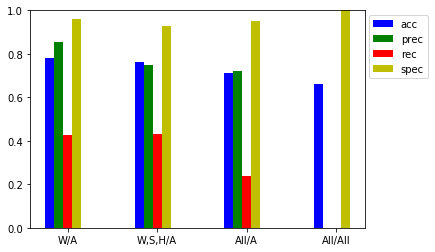

In [55]:
# Results for preprocessing 1 :
accL = np.array([0.782,0.761,0.711,0.662])
recL =  np.array([0.428,0.431,0.237,0.0])
precL = np.array([0.854,0.75,0.722,0.0])
specL = np.array([0.962,0.930,0.953,1.0])
xticks = np.array(['W/A','W,S,H/A','All/A','All/All'])
plotRes(accL,recL,precL,specL,xticks)

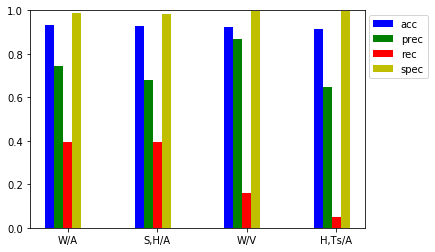

In [56]:
# Results for preprocessing 2 (without dropping rows) :
accL = np.array([0.934,0.930,0.924,0.914])
recL =  np.array([0.394,0.395,0.158,0.05])
precL = np.array([0.743,0.680,0.869,0.646])
specL = np.array([0.986,0.982,0.997,0.997])
xticks = np.array(['W/A','S,H/A','W/V','H,Ts/A'])
plotRes(accL,recL,precL,specL,xticks)

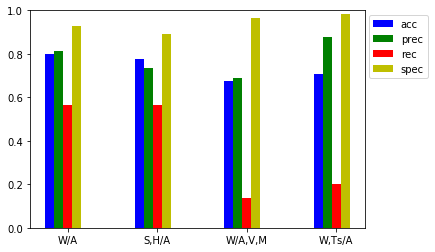

In [57]:
# Results for preprocessing 2 (dropping rows ) :
accL = np.array([0.801,0.776,0.674,0.708])
recL =  np.array([0.567,0.566,0.139,0.2])
precL = np.array([0.813,0.737,0.688,0.879])
specL = np.array([0.929,0.890,0.965,0.985])
xticks = np.array(['W/A','S,H/A','W/A,V,M','W,Ts/A'])
plotRes(accL,recL,precL,specL,xticks)

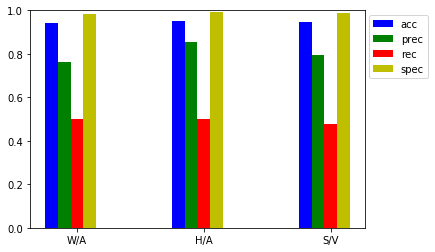

In [58]:
# Results for preprocessing 3 : (without dropping rows) 
accL = np.array([0.944,0.950,0.945])
recL =  np.array([0.5,0.502,0.477])
precL = np.array([0.763,0.854,0.796])
specL = np.array([0.985,0.992,0.988])
xticks = np.array(['W/A','H/A','S/V'])
plotRes(accL,recL,precL,specL,xticks)

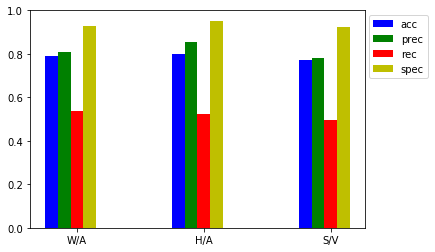

In [59]:
# Results for preprocessing 3 : (dropping rows) 
accL = np.array([0.791,0.801,0.773])
recL =  np.array([0.538,0.523,0.498])
precL = np.array([0.807,0.856,0.779])
specL = np.array([0.929,0.952,0.923])
xticks = np.array(['W/A','H/A','S/V'])
plotRes(accL,recL,precL,specL,xticks)

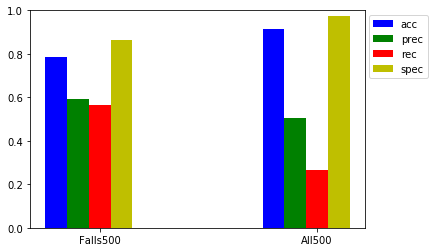

In [60]:
# Results for Conv neural networks : (Comparing falls only vs all trials)
# all of them using only waist accelerations
accL = np.array([0.787,0.912])
recL =  np.array([0.566,0.268])
precL = np.array([0.594,0.504])
specL = np.array([0.864,0.974])
xticks = np.array(['Falls500','All500'])
plotRes(accL,recL,precL,specL,xticks)

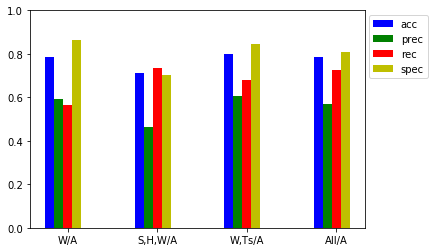

In [61]:
# Results for Conv neural networks : (Using just falls, all with :
# 50 filters, filter size 3, maxpooling=2 (gets the best element from the filter), 500 epochs : 
accL = np.array([0.787,0.711,0.801,0.787])
recL =  np.array([0.566,0.737,0.678,0.725])
precL = np.array([0.594,0.465,0.605,0.571])
specL = np.array([0.864,0.703,0.844,0.809])
xticks = np.array(['W/A','S,H,W/A','W,Ts/A','All/A'])
plotRes(accL,recL,precL,specL,xticks)